Import Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam



Preprocessing The sampled Dtataset

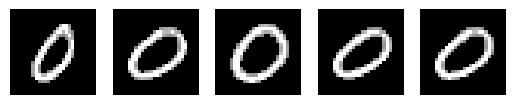

In [2]:
# Function to reduce blur using Gaussian blur
def reduce_blur(image):
    blurred_image = cv2.GaussianBlur(image, (3, 3), 0)
    return blurred_image

# Function to gently sharpen the image
def gentle_sharpen(image):
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    image_8bit = np.uint8(image * 255)
    sharpened_image = cv2.filter2D(image_8bit, -1, sharpening_kernel)
    return sharpened_image / 255.0

# Function to enhance contrast in the image
def enhance_contrast(img):
    img_8bit = np.uint8(img * 255)
    equalized_img = cv2.equalizeHist(img_8bit)
    return equalized_img / 255.0

# Function to binarize the image with a soft threshold
def soft_threshold(image, threshold=0.5):
    thresholded_image = np.where(image < threshold, 0, image)
    return thresholded_image

# Function to load and process an image from the given path
def load_image(img_path, img_size=(28, 28)):
    try:
        img = Image.open(img_path).convert("L").resize(img_size)
        img = np.array(img) / 255.0  
        img = reduce_blur(img)
        img = gentle_sharpen(img)
        img = enhance_contrast(img)
        img = soft_threshold(img, threshold=0.5)
        
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return np.zeros((img_size[0], img_size[1]))  

# Load your dataset of images and labels
data = pd.read_csv("synthetic_mnist_dataset/labels.csv")
data.columns = ['img_path', 'label']

# Process the images and labels into arrays
X = np.array([load_image(path) for path in data['img_path']])  
y = np.array(data['label'])


# Visualize processed images
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i + 1000], cmap='gray')
    plt.axis('off')
plt.show()

# Create unique DataFrame for images and labels, removing duplicates
df = pd.DataFrame(X.reshape(X.shape[0], -1))
df['label'] = y
df_unique = df.drop_duplicates()

# Split unique dataset into features and labels
X_unique = df_unique.iloc[:, :-1].to_numpy()
y_unique = df_unique.iloc[:, -1].to_numpy()

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_unique, y_unique, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Set image shape for grayscale images
image_shape = (28, 28, 1)

# Reshape training, validation, and test sets
x_train = X_train.reshape(X_train.shape[0], *image_shape)
x_validate = X_validate.reshape(X_validate.shape[0], *image_shape)
x_test = X_test.reshape(X_test.shape[0], *image_shape)

Train the CNN 

In [3]:
image_shape = (28, 28, 1)  

# Define the CNN model using Input layer
cnn_model = Sequential([
    Input(shape=image_shape, name='input'),
    Conv2D(filters=16, kernel_size=3, activation='relu', name='conv2d'),
    MaxPooling2D(pool_size=2, name='max_pool'),
    Flatten(name='flatten'),
    Dense(10, activation='softmax', name='output')
])

# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.000001), metrics=['accuracy'])

# Train the model
history = cnn_model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=40,
    verbose=0,
    validation_data=(x_validate, y_validate),
)

# Testing the model
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


# Get the predictions for the test data
predictions = cnn_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
target_names = ["Class {}".format(i) for i in range(10)]  
print(classification_report(y_test, predicted_classes, target_names=target_names, zero_division=0))


Test Loss: 0.7878
Test Accuracy: 0.9604
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
              precision    recall  f1-score   support

     Class 0       1.00      0.97      0.98      1038
     Class 1       0.93      1.00      0.96      1002
     Class 2       0.98      1.00      0.99      1084
     Class 3       0.92      0.96      0.94      1058
     Class 4       0.94      0.90      0.92      1095
     Class 5       1.00      0.92      0.96      1074
     Class 6       0.97      0.99      0.98      1069
     Class 7       1.00      1.00      1.00       984
     Class 8       0.98      0.95      0.97      1039
     Class 9       0.90      0.93      0.92      1057

    accuracy                           0.96     10500
   macro avg       0.96      0.96      0.96     10500
weighted avg       0.96      0.96      0.96     10500



Visualize

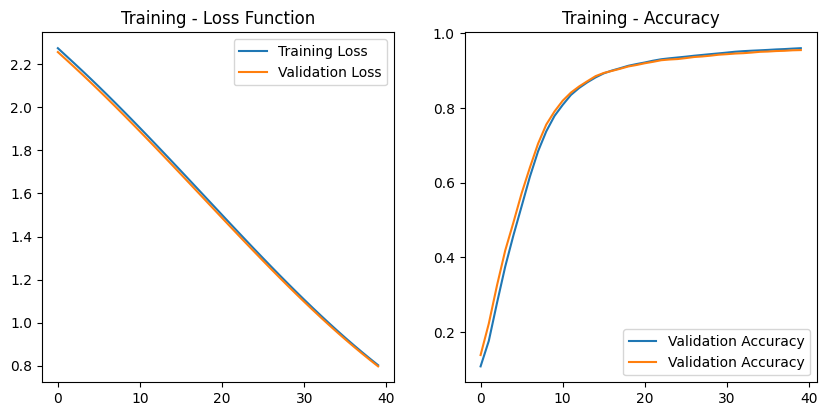

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


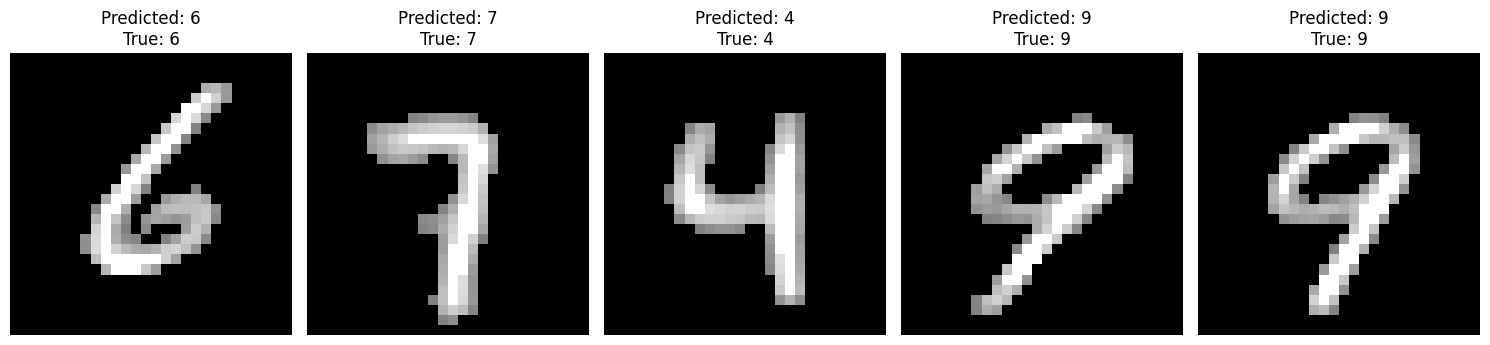

In [4]:

# Plotting training history
plt.figure(figsize=(10, 10))
# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

# Accuracy Plot
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Validation Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training - Accuracy')

plt.show()

# Making predictions
predictions = cnn_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Display a few predictions
plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i + 1)  # Create a subplot for each image
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_classes[i]}\nTrue: {y_test[i]}')
    plt.axis('off')

plt.tight_layout()  
plt.show()


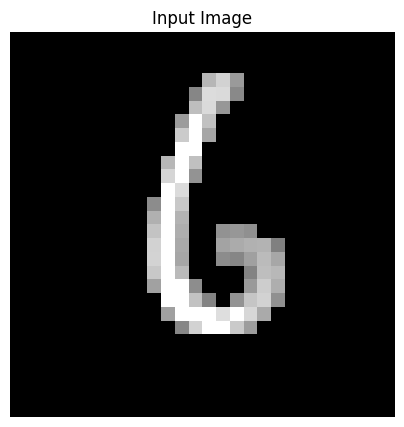

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


c:\Users\Public\Downloads\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input']. Received: the structure of inputs=*
  warnings.warn(


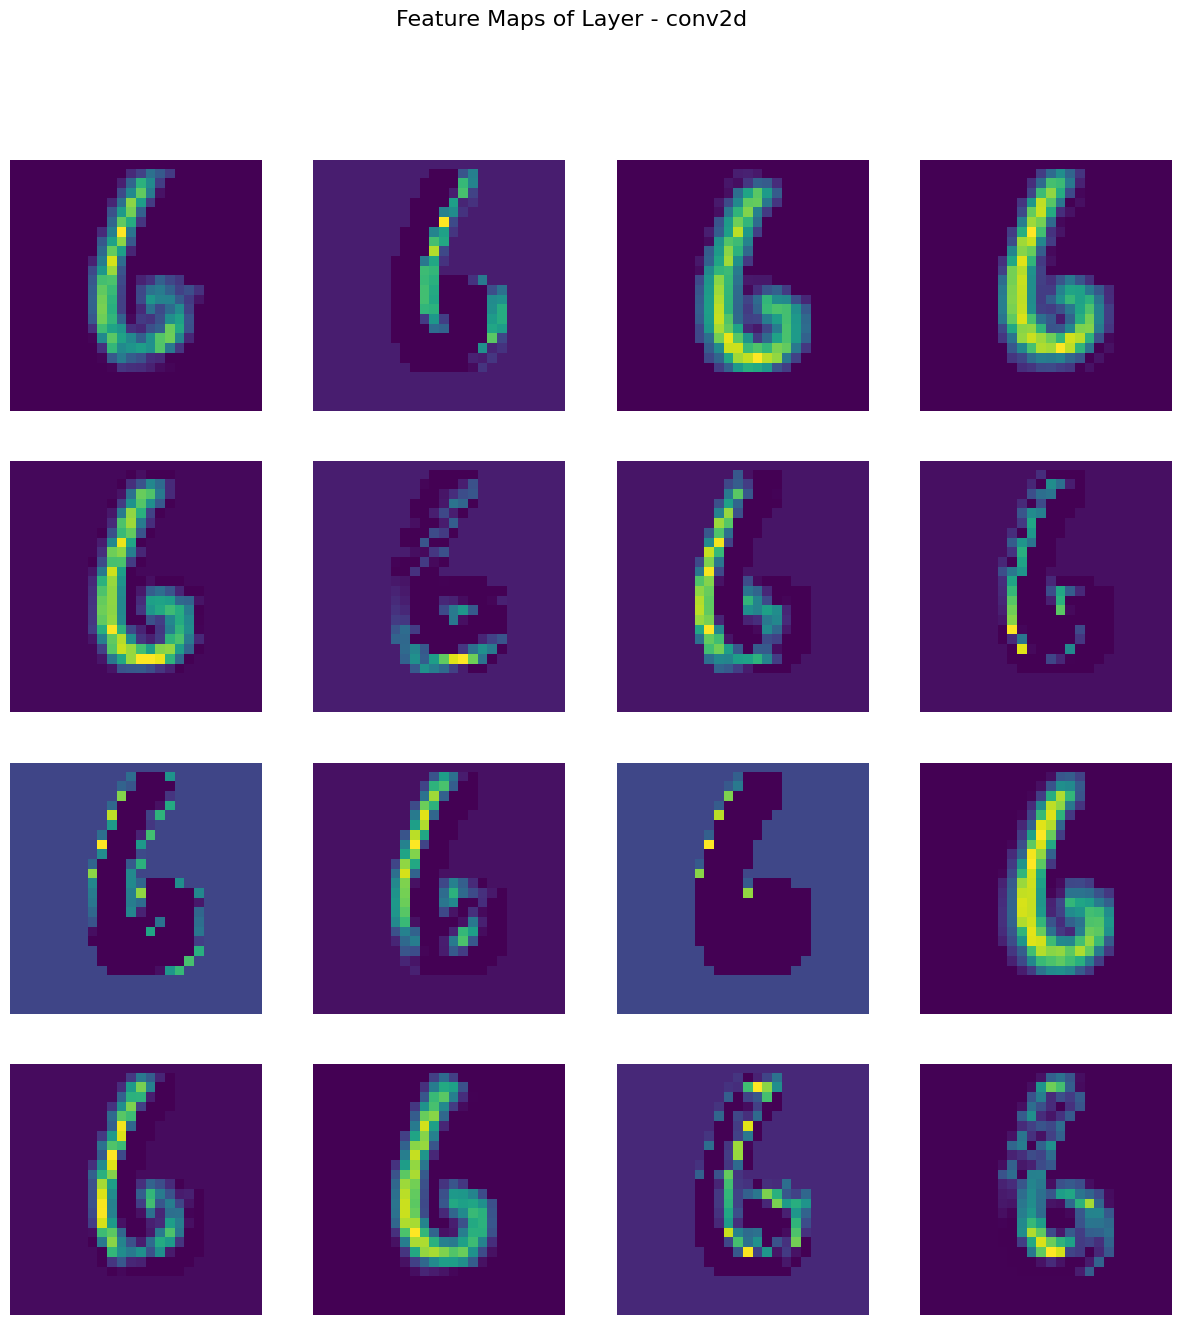

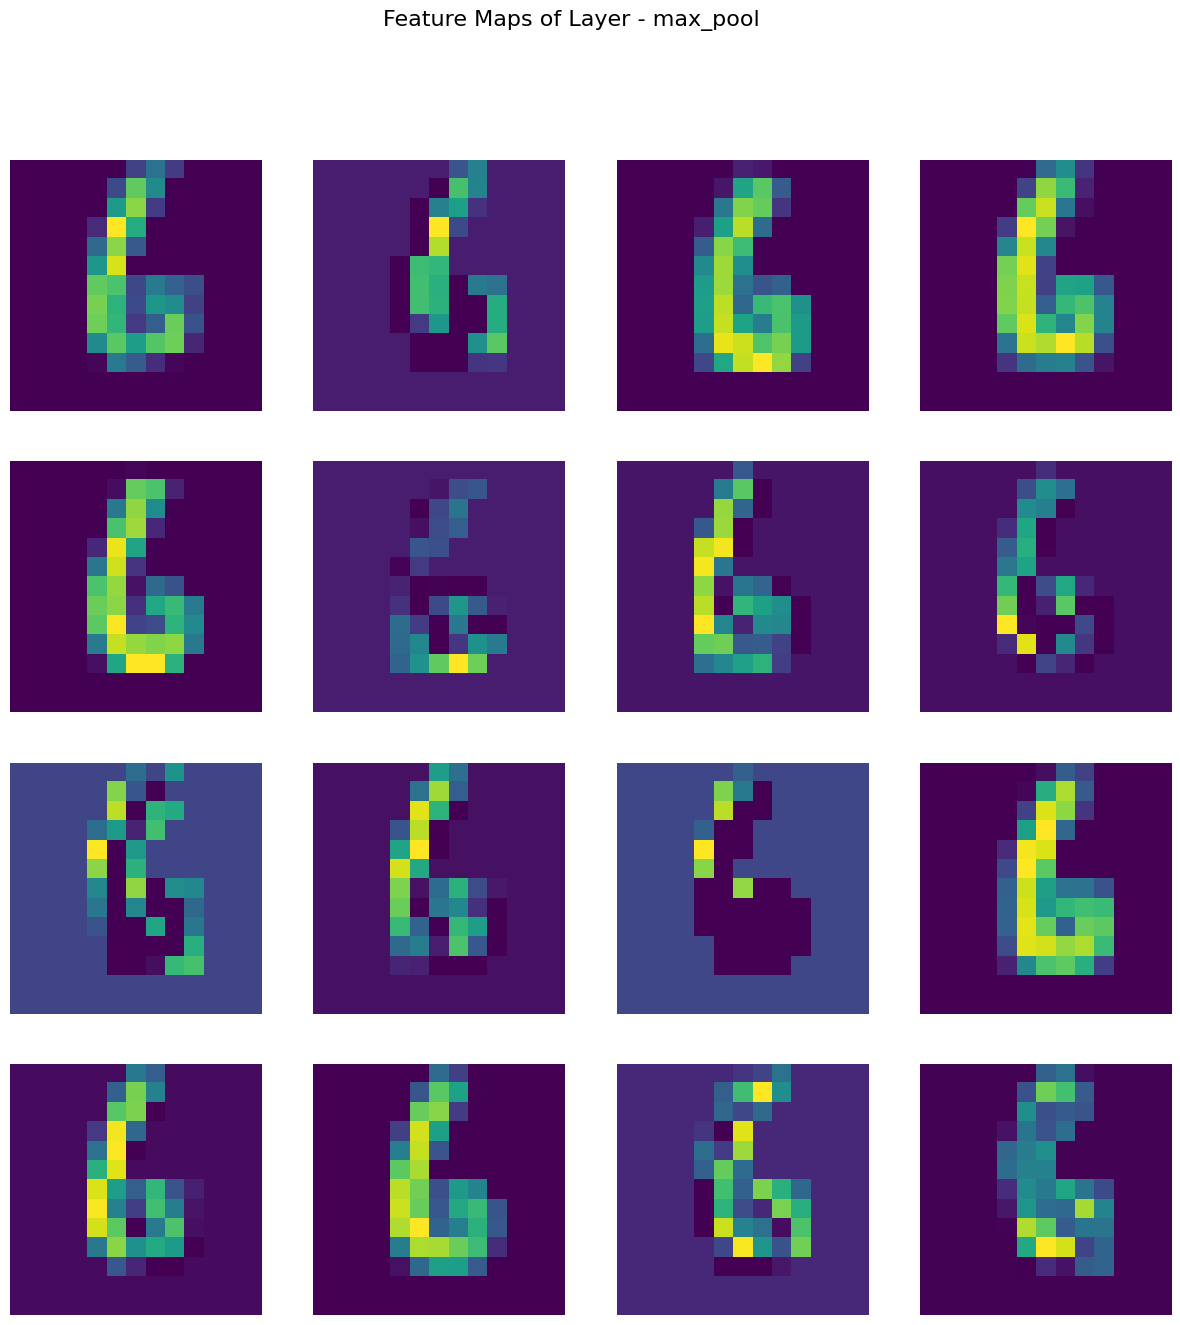

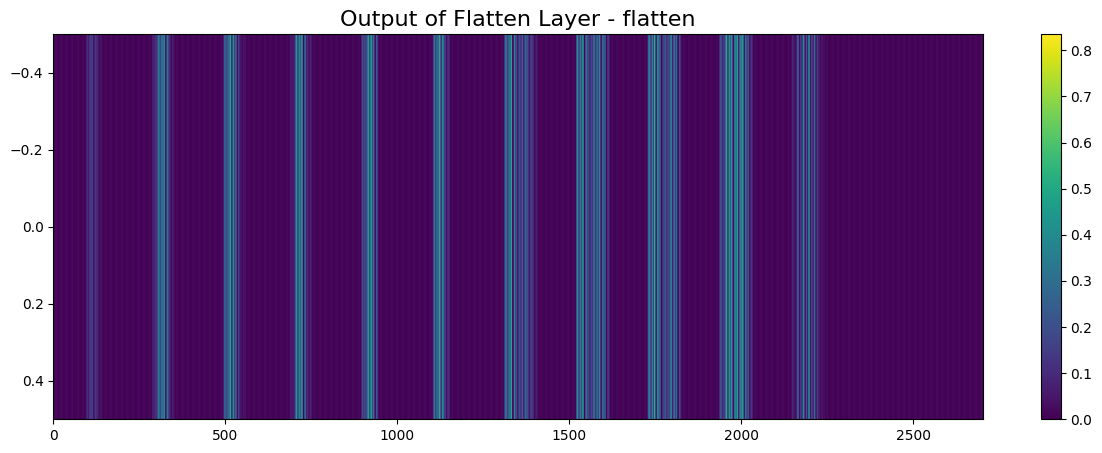

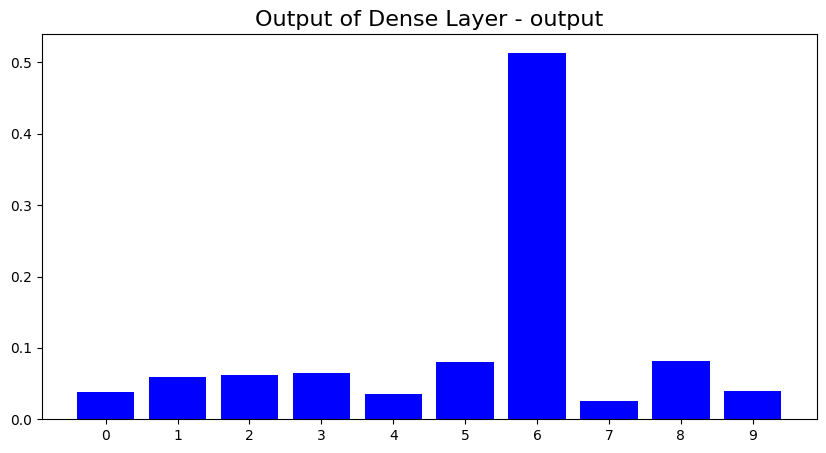

In [5]:
layer_outputs = [layer.output for layer in cnn_model.layers]  
grad_model = Model(inputs=cnn_model.inputs, outputs=layer_outputs)

# Select an image to visualize (first image in the training set)
input_image = np.expand_dims(x_train[200], axis=0)  
input_image = np.expand_dims(input_image, axis=-1)  
# Display the input image
plt.figure(figsize=(5, 5))  
plt.imshow(input_image.reshape(28, 28), cmap='gray') 
plt.title("Input Image")
plt.axis('off')
plt.show()

# Get feature maps from the gradient model
feature_maps = grad_model.predict(input_image)

# Function to plot feature maps for all layers
def plot_feature_maps(feature_maps):
    n_layers = len(feature_maps)
    
    for layer_index in range(n_layers):
        feature_map = feature_maps[layer_index]
        
        # For Conv2D and MaxPooling2D layers (4D output)
        if len(feature_map.shape) == 4:
            n_features = feature_map.shape[-1]
            size = int(np.ceil(np.sqrt(n_features))) 
            plt.figure(figsize=(15, 15)) 
            for i in range(n_features):
                ax = plt.subplot(size, size, i + 1)
                ax.imshow(feature_map[0, :, :, i], cmap='viridis')
                ax.axis('off')
            plt.suptitle(f'Feature Maps of Layer - {cnn_model.layers[layer_index].name}', fontsize=16)
            plt.show()
        
        # For Flatten layer (2D output)
        elif len(feature_map.shape) == 2 and layer_index == n_layers - 2:
            plt.figure(figsize=(15, 5)) 
            plt.title(f'Output of Flatten Layer - {cnn_model.layers[layer_index].name}', fontsize=16)
            plt.imshow(feature_map, aspect='auto', cmap='viridis')
            plt.colorbar()
            plt.show()
        
        # For Dense layer (1D output)
        elif len(feature_map.shape) == 2 and layer_index == n_layers - 1:
            plt.figure(figsize=(10, 5)) 
            plt.title(f'Output of Dense Layer - {cnn_model.layers[layer_index].name}', fontsize=16)
            plt.bar(range(feature_map.shape[-1]), feature_map[0], color='blue')
            plt.xticks(range(feature_map.shape[-1]))
            plt.show()

plot_feature_maps(feature_maps)


The specific shades and their intensities can give insight into what the model is learning. For example:
If a filter is trained to detect edges, areas with bright yellow may indicate strong edge presence, while purples may indicate areas without significant edges

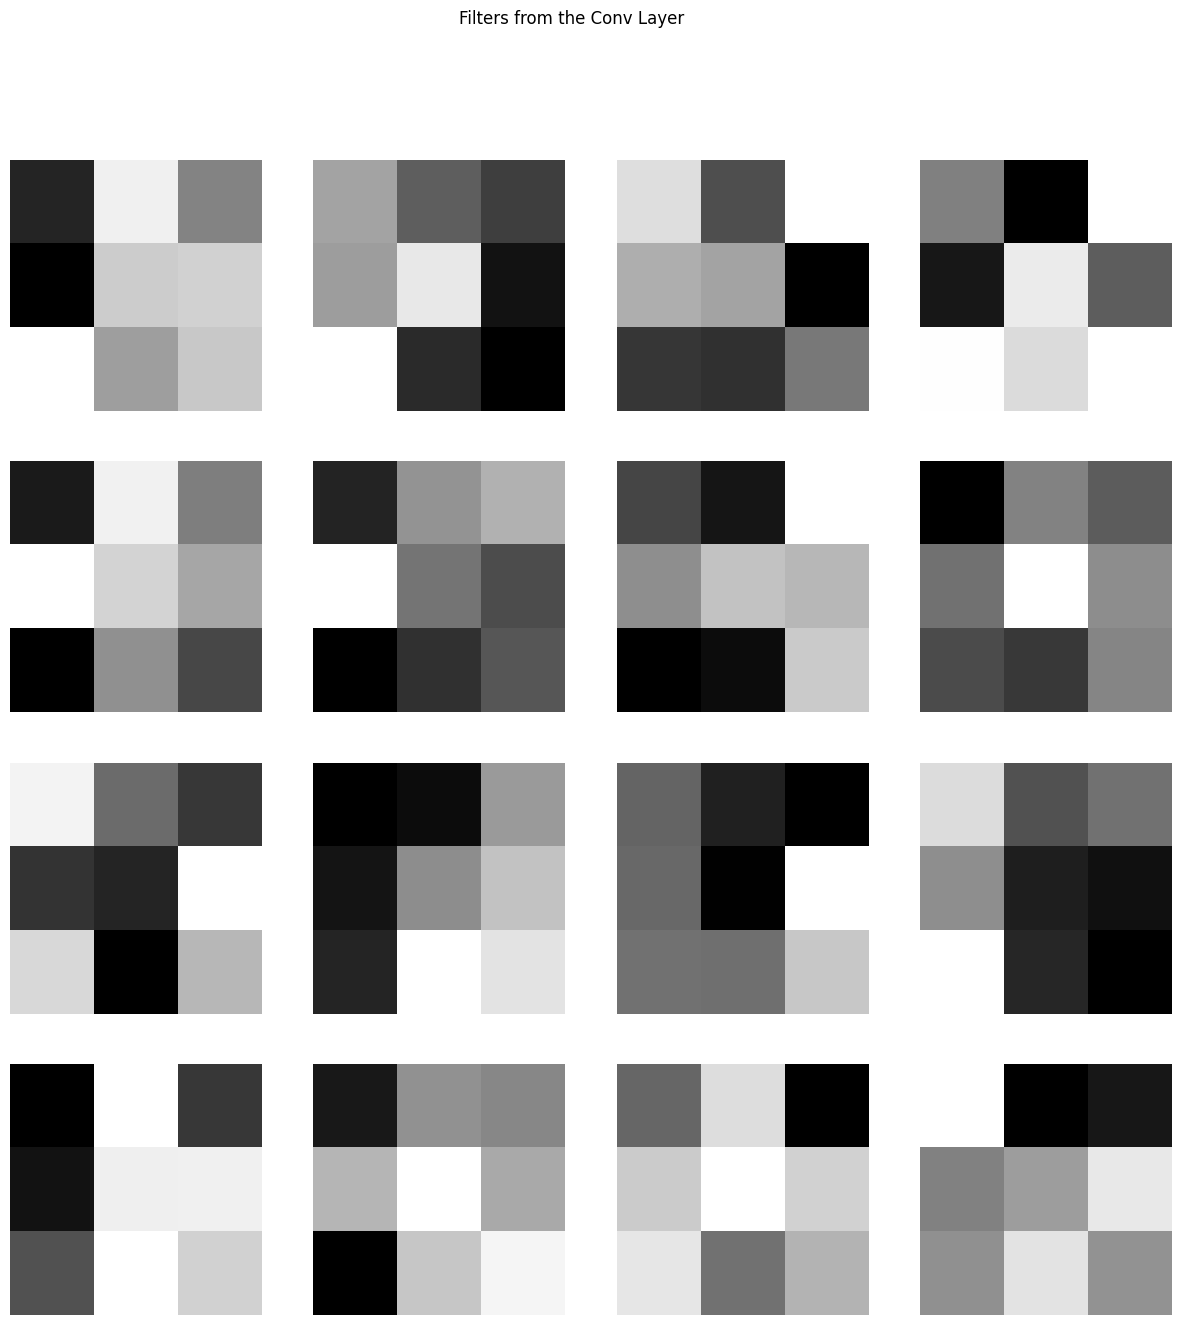

In [6]:
# Get the filters of the first convolutional layer
filters = cnn_model.get_layer('conv2d').get_weights()[0]
def plot_filters(filters):
    n_filters = filters.shape[-1]
    size = int(np.ceil(np.sqrt(n_filters)))  # Calculate grid size
    plt.figure(figsize=(15, 15))
    
    for i in range(n_filters):
        ax = plt.subplot(size, size, i + 1)
        # Normalize filter values to [0, 1] for better visualization
        ax.imshow(filters[:, :, 0, i], cmap='gray')
        ax.axis('off')
    plt.suptitle('Filters from the Conv Layer')
    plt.show()

# Call the function to visualize filters
plot_filters(filters)



Yes, misclassifying a 9 as a 4 in a CNN-Decision Tree (CNN-DT) model could indeed be due to visual similarities in their shapes, especially if parts of their endings or curves resemble each other. Here’s how that might occur:

Similar Feature Patterns:

In the flattened CNN layer, features capture various edges, strokes, and shapes, but not necessarily the whole context of the digit. If both 9 and 4 share features like a vertical line or similar curvature near the endpoints, the Decision Tree may not differentiate them well.
For instance, if the top loop in 9 is less defined or if the 4 has a curved ending, they may appear similar to the model’s feature set.
Decision Boundary Limitations:

Decision Trees, especially with limited depth, create decision boundaries that may struggle with nuanced differences. Since 4 and 9 can be visually similar, the tree might split on features that both digits share, leading to incorrect predictions when they fall on the wrong side of a boundary.
Flattened Layer Ambiguity:

The CNN’s flattened layer condenses high-level image features into a fixed-length vector, but this compression can sometimes result in loss of details that distinguish subtle differences between classes. Thus, certain parts of 9 and 4 might look alike to the tree when extracted from these flattened features.
Gini Impurity in Misclassification:

In the Decision Tree visualization, nodes closer to the misclassified leaf might show a higher Gini impurity. This impurity can indicate that the decision boundary in that region of the tree has difficulty separating classes with similar features, like 9 and 4.

By using only the flatten layer output, you may lose some hierarchical feature information. Flattening is usually done after convolutional and pooling layers that capture spatial relationships, but flattening alone might not retain enough high-level patterns that a dense layer could exploit before the final classification.